# Introduction

In this tutorial we are going to setup OpenCL to do a simple matrix multiply or $$\textbf{A}\textbf{B}=\textbf{C}.$$ This is a matter of taking the dot product of every m'th row of matrix A with every n'th column of matrix B and storing the result in C at location (m,n) as shown in the figure below.

<figure style="float:center">
    <img style="display:inline-block; vertical-align:top; margin:20px" src="images/matrix_multiply.png" width="95%">
    <figcaption style= "text-align:lower; margin:2px; float:bottom; vertical-align:bottom">Figure: simple matrix multiplication </figcaption>
</figure>

Below is some Python code that performs a matrix multiplication and writes the matrices to disk. If you don't have Python installed on your system then don't worry. We can use the files that I made beforehand.

In [2]:
# Code to make the test file
import numpy as np
import os

nrows=1024
ncols=1024

# Make up some arrays of random numbers
matrix_A=np.random.random((nrows, ncols)).astype(np.float32)
matrix_B=np.random.random((nrows, ncols)).astype(np.float32)

# Make up the answer, the resulting Matrix C
matrix_C=np.matmul(matrix_A, matrix_B).astype(np.float32)

# Write the files to grid, notice how I unravel in column major (f) format
# before writing to file
matrix_A.ravel(order="f").tofile(os.path.join("code","array_A_1D.dat"))
matrix_B.ravel(order="f").tofile(os.path.join("code","array_B_1D.dat"))
matrix_C.ravel(order="f").tofile(os.path.join("code","array_C_answer_1D.dat"))

The source code for the OpenCL example is called [mat_mult_cl.cpp](code/mat_mult_cl.cpp) and is located in the [code](code) directory of this tutorial. We are first going to get this code working, and then we explain every component of the process so you can follow along. In order to keep maximum compatibility across devices we are going to use OpenCL 1.2 with mostly C syntax. We will compile the code with a C++ compiler just in case we would like to use C++ features. The OpenCL 1.2 standard document is available at the following [link](https://www.khronos.org/registry/OpenCL/specs/opencl-1.2.pdf).

# Running the code

Now that the application is compiled, run it and observe the results. On my system it shows the following:

```bash
./mat_mult_cl
Platform 0: Experimental OpenCL 2.1 CPU Only Platform, vendor: Intel(R) Corporation, version OpenCL 2.1 LINUX
Platform 1: NVIDIA CUDA, vendor: NVIDIA Corporation, version OpenCL 1.2 CUDA 9.1.83
Platform 0 has 0 devices
Platform 1 has 1 devices
RMS difference is 0.0001142
```

The RMS difference is the [root mean squared](https://en.wikipedia.org/wiki/Root_mean_square) difference between the Python result and the OpenCL result. A small number like this means the code worked successfully and there is very little difference between Python and OpenCL. We can check the result by reading the generated matrix (array_C_1D.dat) in and comparing it to the answer from Python (array_C_answer_1D.dat).

<IPython.core.display.Javascript object>


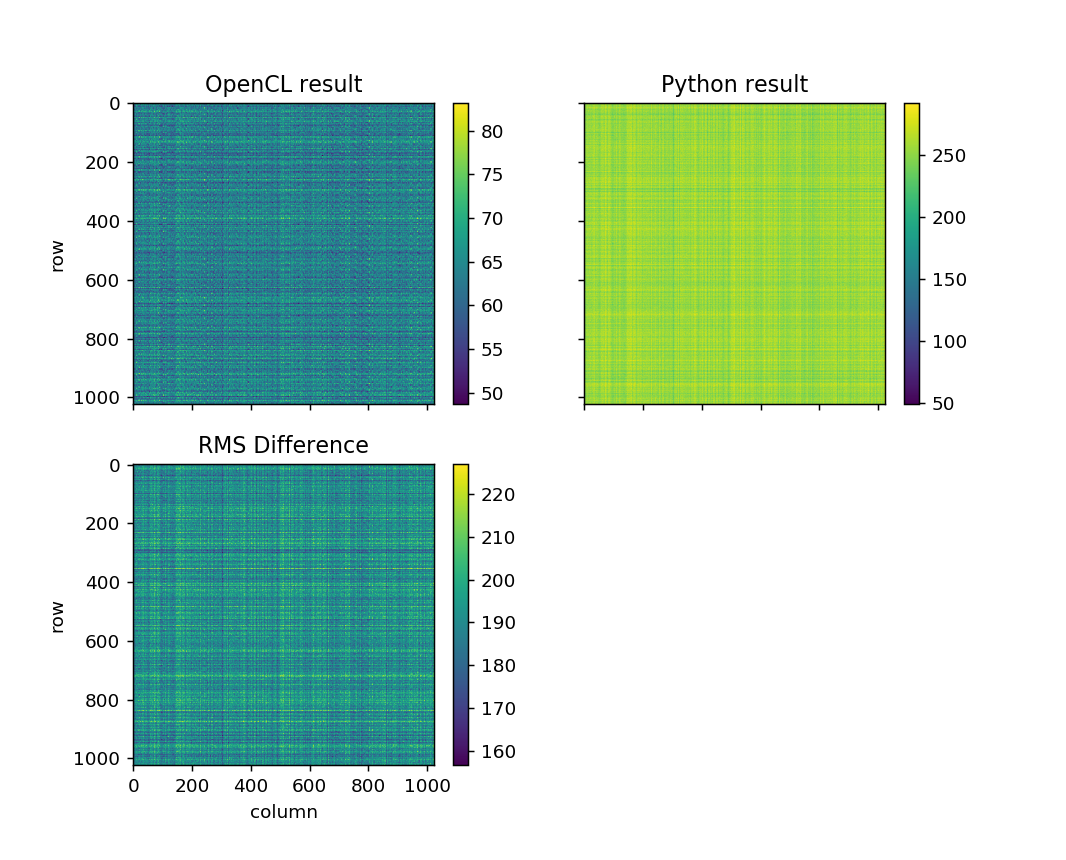

In [1]:
### Checking the result
import numpy as np
import os
import matplotlib.pyplot as plt
% matplotlib notebook

# Read in the two arrays
nrows=1024
ncols=1024

array_C=np.fromfile(os.path.join("code","array_C_1D.dat"), dtype=np.float32)
array_C=array_C.reshape((nrows,ncols), order="f")
array_C_answer=np.fromfile(os.path.join("code","array_C_answer_1D.dat"), dtype=np.float32)
array_C_answer=array_C_answer.reshape((nrows,ncols), order="f")

# Plot the arrays and check the answer
[fig, ax]=plt.subplots(2,2, figsize=(8,6.45), sharex=True, sharey=True)
ax[0,0].set_title("OpenCL result")
ax[0,0].set_ylabel("row")
im1=ax[0,0].imshow(array_C, interpolation="nearest")
fig.colorbar(im1,ax=ax[0,0])
im2=ax[0,1].imshow(array_C_answer, vmin=np.min(array_C), vmax=np.max(array_C_answer), interpolation="nearest")
fig.colorbar(im2,ax=ax[0,1])
ax[0,1].set_title("Python result")
im3=ax[1,0].imshow(np.sqrt((array_C_answer-array_C)**2.0), interpolation="nearest")
ax[1,0].set_title("RMS Difference")
ax[1,0].set_xlabel("column")
ax[1,0].set_ylabel("row")
fig.colorbar(im3, ax=ax[1,0])
fig.delaxes(ax[1,1])
plt.show()

It is clear from the plot that the differences between the OpenCL and Python solutions are very minor. Now lets try to understand what happened.

# Components of a basic OpenCL application

OpenCL defines the following objects to help with running a program.

* **Platform:** each vendor provides a platform on which devices are defined
* **Device:** represents each compute device on a platform, there may be more than one device per platform
* **Buffer:** represents memory on a compute device or the host
* **Kernel:** a lightweight compute function that operates on buffers
* **Context** The domain in which buffers are defined and kernels are executed
* **Program:** represents a set of kernels that are compiled for a platform
* **Command queue:** a queue that you submit commands to in order to do things such as managing memory and running kernels.
* **Event**: keeps track of commands that you have submitted to a queue

The following table lists the dependencies between them:

|Object|Depends on|
|--|--|
|platform|OpenCL library|
|device(s)|platform|
|context|device(s), platform|
|command queue|context, device|
|buffer|context|
|program|context|
|kernel|program|

The figure below is a graphical representation of the different objects in OpenCL and their dependencies:

<figure style="float:center">
    <img style="display:inline-block; vertical-align:top; margin:20px" src="images/device_layout.png" width="640">
    <figcaption style= "text-align:lower; margin:2px; float:bottom; vertical-align:bottom">Figure: Diagram of dependencies for an OpenCL program </figcaption>
</figure>

<figure style="float:center">
    <img style="display:inline-block; vertical-align:top; margin:20px" src="https://www.khronos.org/registry/OpenCL/sdk/1.2/docs/man/xhtml/classDiagram.jpg" width="400">
    <figcaption style= "text-align:lower; margin:2px; float:bottom; vertical-align:bottom">Figure: UML diagram from [khronos website](https://www.khronos.org/registry/OpenCL/sdk/1.2/docs/man/xhtml/classDiagram.jpg) showing the relationships between OpenCL objects</figcaption>
</figure>



# Constructing an OpenCL program

An OpenCL application involves several stages:

1. Platform discovery
2. Device discovery
3. Context creation
1. Command queue allocation
1. Kernel source code preparation
1. Program compilation
1. Kernel compilation
1. Memory allocation 
2. Division of work 
1. Lead-in memory management
1. Kernel execution 
1. Lead-out memory management
2. Resource cleanup

## Including OpenCL header in applications

If you take a peek at the [source code](code/mat_mult_cl.cpp) you will notice the following in the include headers

```C++
#ifdef __APPLE__
    #include "OpenCL/opencl.h"
#else
    #include "CL/cl.hpp"
#endif
```

These are the OpenCL header files, which happen to be in slightly different locations depending on wether or not you are using macOS. This OpenCL include preamble is likely to be more compatible across different software platforms.

## Error checking and standard data types

Every OpenCL call has the ability to make sure that it executed successfully. This is really important to make sure that your application is doing what you want it do. We begin by defining an error checking function called **errchk**

```C
void errchk(cl_int errcode, std::string message) {
    if (errcode!=CL_SUCCESS) {
        printf("Error, OpenCL call, failed at %s with error code %d \n", message.c_str(), errcode);
        exit(OCL_EXIT);
    }
};
```

The enum code CL_SUCCESS is what every OpenCL call is supposed to return if everything is working well. This function will ensure that any errors are caught and their associated help message is printed. Did you notice the **cl_int** integer data type? These data types are to ensure consistent representation of data between host and device and across different host architectures, and are used in host-executed code. The **cl_int** refers to a 32-bit (4 byte) datatype that is guaranteed to be 4 bytes regardless of architecture. There are many other datatypes in the OpenCL API, specificication, as shown in the following tables, (information from this [site](https://www.khronos.org/registry/OpenCL/sdk/1.2/docs/man/xhtml/scalarDataTypes.html)).

|OpenCL integer data types|Explanation|
|:-|:-|
|cl_char|1 byte (8-bit) signed integer|
|cl_uchar|1 byte (8-bit) unsigned integer|
|cl_short|2 byte (16-bit) signed integer|
|cl_ushort|2 byte (16-bit) unsigned integer|
|cl_int|4 byte (32-bit) signed integer|
|cl_uint|4 byte (32-bit) unsigned integer|
|cl_long|8 byte (64-bit) signed integer|
|cl_ulong|8 byte (64-bit) unsigned integer|

In addition to integers there are both scalar and vector floating point data types.

|OpenCL 32-bit floating point data types|Explanation|
|:--|:--|
|cl_float|4 byte (32-bit) single-precision floating point|
|cl_float2|8 byte (64-bit) 2-component single-precision floating point vector|
|cl_float4|16 byte (128-bit) 4-component single-precision floating point vector|
|cl_float8|32 byte (256-bit) 8-component single-precision floating point vector|
|cl_float16|64 byte (512-bit) 16-component single-precision floating point vector|

|OpenCL 64-bit floating point data types|Explanation|
|:--|:--|
|cl_double|8 byte (64-bit) single-precision floating point|
|cl_double2|16 byte (128-bit) 2-component double-precision floating point vector|
|cl_double4|32 byte (256-bit) 4-component double-precision floating point vector|
|cl_double8|64 byte (512-bit) 8-component double-precision floating point vector|
|cl_double16|128 byte (1024-bit) 16-component double-precision floating point vector|

If an optional pragma is included in the code 

```C++
#pragma OPENCL EXTENSION cl_khr_fp16 : enable
```

then you can also have access to 16-bit half-precisions floating point data types, [see here for details](https://www.khronos.org/registry/OpenCL/sdk/1.2/docs/man/xhtml/cl_khr_fp16.html).

|OpenCL 16-bit floating point data types|Explanation|
|:--|:--|
|cl_half|2 byte (16-bit) half-precision floating point|
|cl_half2|4 byte (32-bit) 2-component half-precision floating point vector|
|cl_half4|8 byte (64-bit) 4-component half-precision floating point vector|
|cl_half8|16 byte (128-bit) 8-component half-precision floating point vector|
|cl_half16|32 byte (256-bit) 16-component half-precision floating point vector|


## Platform discovery

Now we are ready to discover the available OpenCL devices on the system. Each hardware device may be different, furthermore the OpenCL driver and library that connects to a device may also have varying levels of capability or maturity. Platforms are for each unique set of device version, platform version, and device capability versions. For example, my Linux workstation has available one GTX 1060 from NVIDIA, and 12 Xeon cores (24 threads) from Intel. Since there are two vendor API's in use there are two platforms. We get the number of compute platforms available using [clGetPlatformIDs](https://www.khronos.org/registry/OpenCL/sdk/1.2/docs/man/xhtml/clGetPlatformIDs.html). 

```C++
    // Useful for checking OpenCL errors
    cl_int errcode;

    // Number to hold the number of platforms
    cl_uint num_platforms;
    
    // First call this to get the number of compute platforms
    errchk(clGetPlatformIDs(0, NULL, &num_platforms),"Get number of platforms");
    
    // Allocate memory for the found number of platforms
    cl_platform_id* platformIDs_1d=(cl_platform_id*)calloc(num_platforms, sizeof(cl_platform_id));
    
    // Now fill in the allocated platform ID's
    errchk(clGetPlatformIDs(num_platforms, platformIDs_1d, &num_platforms),"Filling platform ID's\n");  

```

### Information about each platform

Information on each platform is available using the **[clGetPlatformInfo](https://www.khronos.org/registry/OpenCL/sdk/1.2/docs/man/xhtml/clGetPlatformInfo.html)** function. In this instance we loop through the number of devices and get the OpenCL version that each platform is capable of. 

```C
    // Now get information on each platform that was discovered
    for (int i=0; i<num_platforms; i++) {
        char version[MAXCHAR];
        char vendor[MAXCHAR];
        char name[MAXCHAR];
        
        // Fill the string with platform information
        errchk(clGetPlatformInfo(   platformIDs_1d[i], \
                                    CL_PLATFORM_NAME, 
                                    MAXCHAR, 
                                    name, 
                                    NULL),"Getting name\n");
        // Getting vendor         
        errchk(clGetPlatformInfo(platformIDs_1d[i], 
                                    CL_PLATFORM_VENDOR, 
                                    MAXCHAR, 
                                    vendor, 
                                    NULL),"Getting vendor\n");
        
        // Getting version
        errchk(clGetPlatformInfo(   platformIDs_1d[i], 
                                    CL_PLATFORM_VERSION,
                                    MAXCHAR,
                                    version,
                                    NULL),"Getting version\n");
                                    
        printf("Platform %d: %s, vendor: %s, version %s\n", i, name, vendor, version);
    }
```


## Device discovery

Once we have the platform information then we can get the number of devices associated with each platform. This is acheived using the **[clGetDeviceIDs](https://www.khronos.org/registry/OpenCL/sdk/1.2/docs/man/xhtml/clGetDeviceIDs.html)** function.

```C++
    // Select the device we are going to use 
    cl_device_type target_device=CL_DEVICE_TYPE_ALL;

    // Now get the number of valid devices for each platform 
    // And the total number of valid devices
    cl_uint* ndevices_1d=(cl_uint*)calloc(num_platforms, sizeof(cl_uint));
    int ndevices=0;
    int num_valid_platforms=0;
    for (int i=0; i<num_platforms; i++) {
        cl_uint ndevice=0;
        errchk(clGetDeviceIDs(      platformIDs_1d[i],
                                    target_device,
                                    0,
                                    NULL,
                                    &ndevice),"Getting number of devices");
        
        if (ndevice>0) {
            // We have more than one device in this platform
            ndevices_1d[i]=ndevice;
            ndevices+=ndevice;
            num_valid_platforms++;
        } 

        printf("Platform %d has %d devices\n", i,  ndevices_1d[i]);
    }
    
    // Make sure we have at least one valid platform
    assert(num_valid_platforms>=1);

```

Notice how I used the **CL_DEVICE_TYPE_ALL** as the target device when polling the number of devices? This was to select the appropriate OpenCl device. If I chose a different value for this I can select for different device types. The table below shows a number of valid device types and their explanation, see [here](https://www.khronos.org/registry/OpenCL/sdk/1.2/docs/man/xhtml/clGetDeviceIDs.html) for details.

|OpenCL device type selector | explanation|
|:--|:--|
| CL_DEVICE_TYPE_ALL | all OpenCL-capable devices |
| CL_DEVICE_TYPE_GPU | only GPU-based OpenCL devices |
| CL_DEVICE_TYPE_CPU | only CPU-based OpenCL devices |
| CL_DEVICE_TYPE_ACCELERATOR | dedicated OpenCL accelerators |
| CL_DEVICE_TYPE_CUSTOM | dedicated accelerators that don't support OpenCL C |
| CL_DEVICE_TYPE_DEFAULT | Default OpenCL device, cannot be of type CL_DEVICE_TYPE_CUSTOM |


Now allocate memory for the devices and populate it with device information using the same call to **clGetDeviceIDs**, but with the second and third-last arguments filled in.

```C++
    // Create a 2D array for devices and fill it with device information for each platform
    // that has one or more devices in it
    cl_device_id** devices_2d=(cl_device_id**)calloc(num_valid_platforms, sizeof(cl_device_id*));
    int platform_counter=0;
    for (int i=0; i<num_platforms; i++) {
        // Skip over platforms with no devices in them 
        if (ndevices_1d[i]>0) {
            // Construct the devices array to hold the desired number of devices
            devices_2d[platform_counter]=(cl_device_id*)calloc(ndevices_1d[i], sizeof(cl_device_id));
        
            // Fill the devices array
            errchk(clGetDeviceIDs(  platformIDs_1d[i],
                                    target_device,
                                    ndevices_1d[i],
                                    devices_2d[platform_counter],
                                    NULL),"Filling device arrays");
            platform_counter++; 
        }
    }
```

The figure below shows what is happening with **devices_2d**. First we create an array of type **cl_device\***, then for each valid platform we create an array of type **cl_device**.

<figure style="float:center">
    <img style="display:inline-block; vertical-align:top; margin:20px" src="images/device_allocation.png" width="350">
    <figcaption style= "text-align:lower; margin:2px; float:bottom; vertical-align:bottom">Figure: memory layout of the devices_2d array </figcaption>
</figure>

## Creating the contexts

A context provides the foundation for creating memory buffers and compiling programs. Along with devices, it also provides the foundation for constructing command queues. Creating a command queue involves some complexity with the **cl_context_properties** structure. In the code below we create a context for each "valid" platform, that is, for each platform with the devices we want.

```C++
    // Now make a context for each valid platform
    // Allocate memory to store the contexts
    cl_context* contexts_1d=(cl_context*)calloc(num_valid_platforms, sizeof(cl_context));
    platform_counter=0;
    for (int i=0; i<num_platforms; i++) {
        if (ndevices_1d[i]>0) {
            // We have a valid platform, create a context.
            // Handling the context properties is tricky, here is how to do it
            const cl_context_properties prop[] = {CL_CONTEXT_PLATFORM, 
                                                  (cl_context_properties)platformIDs_1d[i], 
                                                  0 };

            // Now create a context using the platform and devices
            contexts_1d[platform_counter]=clCreateContext(prop, 
                                                          ndevices_1d[i], 
                                                          devices_2d[platform_counter], 
                                                          NULL, 
                                                          NULL, 
                                                          &errcode);

            errchk(errcode, "Creating contexts");
            platform_counter++;
        }
    }
```


## Creating the command queues

Now that we have contexts and devices we can create a number of command queues. In the preamble we defined  **NQUEUES_PER_DEVICE** as the number of command queues to construct per device. Having more than one command queue per device unlocks aynchronous IO on devices that support it. For example one command queue could be copying data whereas the other can be executing a kernel at the same time.

```C++
    // Now create command queues for each valid device;
    int num_command_queues=ndevices*NQUEUES_PER_DEVICE;
    cl_command_queue* command_queues_1d=(cl_command_queue*)calloc(num_command_queues, sizeof(cl_command_queue));
    platform_counter=0;
    int queue_counter=0;
    for (int i=0; i<num_platforms; i++) {
        for (int j=0; j<ndevices_1d[i]; j++) {
            for (int k=0; k<NQUEUES_PER_DEVICE; k++) {
                command_queues_1d[queue_counter]=clCreateCommandQueue(  contexts_1d[platform_counter],
                                                                        devices_2d[platform_counter][j], 
                                                                        0, 
                                                                        &errcode);
                queue_counter++;
            }

        }
        if (ndevices_1d[i]>0) platform_counter++;
    }
```

Notice the "0" in the the call to **clCreateCommandQueue**. Command queues can be specified to execute in-order or out-of-order so as to unlock potential optimisations. If nothing is specified (i.e. 0) then the command queue executes commands in-order, that is, the command queue executes operations in the order they are submitted to the queue. You can specify and out-of-order queue by putting the parameter **CL_QUEUE_OUT_OF_ORDER_EXEC_MODE_ENABLE** where the 0 should be. You can also add (using the bitwise or '|' operator) the parameter **CL_QUEUE_PROFILING_ENABLE** to enable profiling of commands. For example:

```C++
    clCreateCommandQueue(  contexts_1d[platform_counter],
                           devices_2d[platform_counter][j], 
                           CL_QUEUE_OUT_OF_ORDER_EXEC_MODE_ENABLE | CL_QUEUE_PROFILING_ENABLE, 
                           &errcode);
```

enables both out-of-order execution and profiling. Now you should have an OpenCL environment setup like the figure below.

<figure style="float:center">
    <img style="display:inline-block; vertical-align:top; margin:20px" src="images/device_layout.png" width="80%">
    <figcaption style= "text-align:lower; margin:2px; float:bottom; vertical-align:bottom">Figure: Diagram of dependencies for an OpenCL program </figcaption>
</figure>

## Setting up the problem

Now that we have the OpenCL environment setup and command queues allocated allocate memory to store matrices A, B, and C, and read information into these arrays. 

```C++
    // We are going to do a simple array multiplication for this example, 
    // using raw binary files for input and output
    size_t nrows=1024;
    size_t ncols=1024;
    size_t element_size=sizeof(float);
    size_t nelements=nrows*ncols;
    size_t nbytes=nelements*element_size;

    // Allocate memory for the input and output arrays
    float* array_A_1D=(float*)malloc(nbytes);
    float* array_B_1D=(float*)malloc(nbytes);
    float* array_C_1D=(float*)malloc(nbytes);
    float* array_C_answer_1D=(float*)malloc(nbytes);

    // Read input data, this must be of size nrows*ncols*element_size, 
    // and the files array_A_1D.dat, array_B_1D.dat and array_C_answer_1D.dat 
    // must be in the current directory
    
    FILE* fp;
    // Read in matrix A
    fp=fopen("array_A_1D.dat","r");
    assert(fp!=NULL);
    fread(array_A_1D, element_size, nelements, fp);
    fclose(fp);

    // Read in matrix B
    fp=fopen("array_B_1D.dat","r");
    assert(fp!=NULL);
    fread(array_B_1D, element_size, nelements, fp);
    fclose(fp);

    // Read in the answer
    fp=fopen("array_C_answer_1D.dat","r");
    assert(fp!=NULL);
    fread(array_C_answer_1D, element_size, nelements, fp);
    fclose(fp); 

```

Keep in mind that with OpenCL it is more consistent with the runtime to use column-major array ordering. So if your matrices are row-major, such as in C and Python, then you need to be aware that what OpenCL sees as the first axis is actually the last axes. The following Python code generates binary data files that are suitable for input to the C function.

## Selecting a command queue

We have made a number of command queues however we only need one for this example. We select the first command queue and obtain the device and context associated with this command queue.

```C++
    // Select a command queue to use from the pool of valid command queues
    cl_command_queue command_queue=command_queues_1d[0];
    
    // Get the context, device, and platform from the selected command queue
    cl_context context;
    cl_device_id device;

    errchk(clGetCommandQueueInfo(   command_queue, 
                                    CL_QUEUE_CONTEXT, 
                                    sizeof(context), 
                                    &context,
                                    NULL), "Getting the context");

    errchk(clGetCommandQueueInfo(   command_queue, 
                                    CL_QUEUE_DEVICE, 
                                    sizeof(device), 
                                    &device,
                                    NULL), "Getting the device");
```

## OpenCL memory allocation

OpenCL buffers are where memory is allocated for use in OpenCL kernels. The buffers live on the host and are copied into and out of the devices as needed. We allocate memory for the OpenCL buffers using the OpenCL command [**clCreateBuffer**](https://www.khronos.org/registry/OpenCL/sdk/1.2/docs/man/xhtml/clCreateBuffer.html) as follows:

```C++
    // Make buffers for bringing data in and out of the computation
    cl_mem buffer_A=clCreateBuffer(context, CL_MEM_READ_WRITE, nbytes, NULL, &errcode);
    errchk(errcode, "Creating buffer_A");
    cl_mem buffer_B=clCreateBuffer(context, CL_MEM_READ_WRITE, nbytes, NULL, &errcode);
    errchk(errcode, "Creating buffer_B");
    cl_mem buffer_C=clCreateBuffer(context, CL_MEM_READ_WRITE, nbytes, NULL, &errcode);
    errchk(errcode, "Creating buffer_C");
```

Setting **CL_MEM_READ_WRITE** means we allocate memory initially on the host and move it to and from and from the OpenCL  device as needed, and enable read-write access to that memory. There are other flags which achieve some special functionality for the buffer, namely:

|OpenCL memory flag| what it does|
|:-- |:-- |
|CL_MEM_READ_WRITE| enable a read-write buffer that is allocated on the host and copied to and from the device as needed |
|CL_MEM_READ_ONLY| enable a read-only buffer that is allocated on the host and copied from the device as needed |
|CL_MEM_WRITE_ONLY| enable a write-only buffer that is allocated on the host and copied to the device as needed |
|CL_MEM_USE_HOST_PTR| use host memory as storage for the buffer, memory accessible from devices |
|CL_MEM_ALLOC_HOST_PTR| allocate pinned (fast) memory on the host that is accessible from devices |
|CL_MEM_COPY_HOST_PTR| allocate a buffer and fill it with memory copied from the host |
|CL_MEM_HOST_WRITE_ONLY| specify that the host will only write to the buffer, it may unlock optimisations |
|CL_MEM_HOST_READ_ONLY| specify that the host will only read from the buffer, it may unlock optimisations |
|CL_MEM_HOST_NO_ACCESS| specify that the host will have no access to the buffer, it may unlock optimisations |


If you know a buffer is going to reside primarily on a compute device, or you want to make sure the buffer resides on the host you can explicitly move the buffer between host and device using **[clEnqueueMigrateMemObjects](https://www.khronos.org/registry/OpenCL/sdk/1.2/docs/man/xhtml/clEnqueueMigrateMemObjects.html)**. A call to this command would look like this.

```C
clEnqueueMigrateMemObjects(command_queue, 1, buffer_A, 0, 0, NULL, NULL);
```


## Division of work, how OpenCL maps work to kernels

At this point we need to talk about how OpenCL divides up the work on the available compute device. Each device exposes hardware threads, whose job is to run a compute kernel. This smallest unit of work is called a **work item**. Work items are grouped into collections called **work groups** that can be 1D, 2D or 3D. The device manufacturer imposes limits on the **local_size**, or how large a work group may be. Generally we are talking upwards of 64 elements on a side. Devices such as GPU's perform optimally with local sizes in powers of 2 (i.e 16) along each dimension.

<figure style="float:center">
    <img style="display:inline-block; vertical-align:top; margin:20px" src="images/workgroup_layout.png" width="80%">
    <figcaption style= "text-align:lower; margin:2px; float:bottom; vertical-align:bottom">Figure: How work is allocated in an OpenCL program. </figcaption>
</figure>

Work groups are then grouped into a larger structure called a grid, whose **global_size** is measured as the number of work items along each dimension. It is up to you what global size to choose, and if you choose a local size then your choice must divide evenly into global_size along each dimension. In the example we have decided to make the **global_size** as the same dimensions as the output matrix C, that is, we have one kernel execution for every element of C.

## Preparing the kernel source

Now that we have allocated the buffers we need to specify the source code for the kernel that operates on that memory. One method is to put kernels in a file and read the file in at runtime. Another method is to specify the kernel source as a string within the program, as shown below:

```C
    // Now specify the kernel source
    const char* kernel_source="__kernel void mat_multiply ( __global float* A, \n\
                                                            __global float* B, \n\
                                                            __global float* C, \n\
                                                            int nrows_A, \n\
                                                            int nrows_B) { \n\
                                                            
        // nrows and ncols specify the dimensions of the output matrices \n\
        // Using Fortran ordering \n\
        size_t i0=get_global_id(0); \n\
        size_t i1=get_global_id(1); \n\
        // Loop over columns of A and rows of B \n\
        float temp=0.0; \n\
        for (int n=0; n<nrows_B; n++) { \n\
            // C has the same number of rows as A, and the same number of columns as B \n\
            temp+=A[n*nrows_A+i0]*B[i1*nrows_B+n]; \n\
        } \n\
        C[i1*nrows_A+i0]=temp; \n\
    }";
```

The syntax is mostly C like, did you notice the **__kernel** and **__global** qualifiers. They are OpenCL extensions to signify both OpenCL kernels and the different memory types available to an OpenCL kernel. The table below shows what memory types there are and where they are located on the device.

|Memory type|where it is|visible to what|
|:--|:--|:--|
|__global|main memory of the device|every work item|
|__constant|main memory of the device|read_only access for every work item|
|__local|fast shared memory of the device|only fellow work items in a work group|
|__private|fast register memory in the device|exclusive to the work item|



## Making a program from the kernel sources

Programs are like software libraries of compiled OpenCL code. They may be created from either source code or "binary" code that may be in a lower-level intermediate format such as NVIDIA's PTX format. The "binary" code option may be a good choice in order to protect intellectual property investments. In this instance we build a program from the kernel source outlined above.

```C++
   // Turn this source code into a program
    cl_program program=clCreateProgramWithSource(   context, 
                                                    1, 
                                                    &kernel_source,
                                                    NULL,
                                                    &errcode);
    errchk(errcode, "Creating program from source");
```

If we were to create the program from binary sources we would use the [clCreateProgramWithBinary](https://www.khronos.org/registry/OpenCL/sdk/1.2/docs/man/xhtml/clCreateProgramWithBinary.html) option.


## Building the program

Now that the program has been created from either binary or source code, we build it for any number of devices in the given context at runtime using [clBuildProgram](https://www.khronos.org/registry/OpenCL/sdk/1.2/docs/man/xhtml/clBuildProgram.html) as follows:

```C++
    // Build the program 
    const char* build_opts="";
    errcode=clBuildProgram( program,
                            1,
                            &device,
                            build_opts,
                            NULL,
                            NULL);
```

The documentation shows a wide variety of build options that can be passed to the compiler. We chose not to use any of them.

It is good practice to check for error messages on the build in case there was any problems. For example there might be a syntax error in the kernel code. This code fetches the build log and prints it to standard output.

```C++
    // Check the program build
    if (errcode!=CL_SUCCESS) {
        size_t elements;
        errchk(clGetProgramBuildInfo(   program,
                                        device,
                                        CL_PROGRAM_BUILD_LOG,
                                        0,
                                        NULL,
                                        &elements),"Checking build log");

        // Make up the build log string
        char* buildlog=(char*)calloc(elements, 1);

        errchk(clGetProgramBuildInfo(   program,
                                        device,
                                        CL_PROGRAM_BUILD_LOG,
                                        elements,
                                        buildlog,
                                        NULL), "Filling the build log");
        printf("Build log is %s\n", buildlog);
        exit(OCL_EXIT);
    }
```

## Create a kernel from the built program

As shown in the diagram of OpenCL objects, kernels are part of program objects and are submitted (or enqueued) to command queues at runtime. We create a handle to a kernel in a compiled program using the [clCreateKernel](https://www.khronos.org/registry/OpenCL/sdk/1.2/docs/man/xhtml/clCreateKernel.html) function. Notice that refer to the kernel by its name "mat_multiply".

```C++
    // Create a kernel from the built program
    cl_kernel kernel=clCreateKernel(program,"mat_multiply",&errcode);
```

## Upload memory to the compute buffers

The programs have been compiled and the kernels have been constructed, we are now ready to write memory from the host to the OpenCL buffers that represent matrices A and B. The OpenCL library command to do this is [clEnqueueWriteBuffer](https://www.khronos.org/registry/OpenCL/sdk/1.2/docs/man/xhtml/clEnqueueWriteBuffer.html).

```C++
       // Write memory to the buffer from the host device
       errchk(clEnqueueWriteBuffer( command_queue,
                                    buffer_A,
                                    CL_TRUE,
                                    0,
                                    nbytes,
                                    array_A_1D,
                                    0,
                                    NULL,
                                    NULL), "Writing to buffer_A from host");

    errchk(clEnqueueWriteBuffer(    command_queue,
                                    buffer_B,
                                    CL_TRUE,
                                    0,
                                    nbytes,
                                    array_B_1D,
                                    0,
                                    NULL,
                                    NULL), "Writing to buffer_B from host");

```

Recall that **nbytes** is the number of bytes in matrices **array_A_1D** and **array_B_1D**. There are actually two modes to **clEnqueueWriteBuffer**, blocking and non-blocking. Blocking writes (CL_TRUE) means that the host program waits for the write to complete. Non-blocking writes (CL_FALSE) means that the call to **clEnqueueWriteBuffer** returns immediately and the transfer occurs in the background. In a more advanced section of this course we cover how to synchronize enqueued commands using events.


## Set arguments to the kernel

At this point we set arguments to the kernel using [clSetKernelArg](https://www.khronos.org/registry/OpenCL/sdk/1.2/docs/man/xhtml/clSetKernelArg.html). Generally we pass the address of the object (except for images) and the size of the object whose address we are passing. For example, the address of **buffer_A** gets passed in to the kernel, where it is interpreted as a floating point array.

```C++
    // Set arguments to the kernel
    clSetKernelArg(kernel, 0, sizeof(cl_mem), &buffer_A );
    clSetKernelArg(kernel, 1, sizeof(cl_mem), &buffer_B );
    clSetKernelArg(kernel, 2, sizeof(cl_mem), &buffer_C );
    clSetKernelArg(kernel, 3, sizeof(int), &nrows );
    clSetKernelArg(kernel, 4, sizeof(int), &nrows );
```

## Run the kernel

We now come to the apex of our program, the point where we enqueue the OpenCL kernel to the command queue. The command to do this  [clEnqueueNDRangeKernel](https://www.khronos.org/registry/OpenCL/sdk/1.2/docs/man/xhtml/clEnqueueNDRangeKernel.html) takes a command queue, a kernel and a global size. As previously discussed, we set **global_size** to the dimensions of matrix C so that every item in C has a corresponding work item.

```C++
    // Number of dimensions in the kernel
    cl_uint work_dim=2;
    const size_t global_work_size[]={ nrows, ncols };
    cl_event kernel_event;

    // Now enqueue the kernel
    errchk(clEnqueueNDRangeKernel(  command_queue,
                                    kernel,
                                    work_dim,
                                    NULL,
                                    global_work_size,
                                    NULL,
                                    0,
                                    NULL,
                                    &kernel_event),"Running the kernel");
```

Kernel executions are asynchronous, that is, they return control immediately to the calling program. If we used a command queue that accepts out-of-order execution then there may be a danger that we use the buffer memory before the kernel is finished with it. This is where events play a role. By passing **kernel_event** to the **clEnqueueNDRangeKernel** we now have an event handle that we can pass to other commands such as **clEnqueuReadBuffer** so these other commands wait for the kernel to finish. Events can be in any of the four valid states, anything else is an error condition.

|State|Explanation|
|:--|:--|
|CL_QUEUED| command has been enqueued in the command queue|
|CL_SUBMITTED| command has been submitted to the queue's OpenCL device|
|CL_RUNNING| command is currently running on the queue's OpenCL device|
|CL_COMPLETE| command has finished executing|

## Download the data

All that remains is to get data back from the device. We read memory from the buffer into host memory using [clEnqueueReadBuffer](https://www.khronos.org/registry/OpenCL/sdk/1.2/docs/man/xhtml/clEnqueueReadBuffer.html). We specify that the read is blocking and will explicitly wait for **kernel_event** to be in state CL_COMPLETE before running.

```C++
    // Read memory from the buffer to the host
    errchk(clEnqueueReadBuffer(   command_queue,
                            buffer_C,
                            CL_TRUE,
                            0,
                            nbytes,
                            array_C_1D,
                            1,
                            &kernel_event,
                            NULL), "Copying matrix C from device to host");


    // Write the data to file
    fp=fopen("array_C_1D.dat","w");
    fwrite(array_C_1D, element_size, nrows*ncols, fp);
    fclose(fp);
```

## Clean up

It is good practice to clean up the command queues and contexts that have been created. We wait for the command queue to drain using the [clFinish](https://www.khronos.org/registry/OpenCL/sdk/1.2/docs/man/xhtml/clFinish.html) command, and release the command queue and context with [clReleaseCommandQueue](https://www.khronos.org/registry/OpenCL/sdk/1.2/docs/man/xhtml/clReleaseCommandQueue.html) and [clReleaseContext](https://www.khronos.org/registry/OpenCL/sdk/1.2/docs/man/xhtml/clReleaseContext.html). This releases those objects in memory if they are not reference anywhere else.  We finish by using a **free** on the allocated memory and we are done.

```C++
    // Wait for all command queues to finish
    // Release the command queues
    for (int i=0; i<num_command_queues; i++) {
        errchk(clFinish(command_queues_1d[i]),"Finishing up command queues");
        errchk(clReleaseCommandQueue(command_queues_1d[i]), "Releasing command queues");
    }

    // Release the contexts and free the devices associated with each context
    for (int i=0; i<num_valid_platforms; i++) {
        errchk(clReleaseContext(contexts_1d[i]),"Releasing the context");
        free(devices_2d[i]);
    }

    // Clean up memory    
    free(command_queues_1d);
    free(ndevices_1d);
    free(platformIDs_1d);
    free(contexts_1d);
    free(devices_2d);
    free(array_A_1D);
    free(array_B_1D);
    free(array_C_1D);
```

Congratulations on making it through this tutorial! Most of the basics of OpenCL programs are in this example. If you have any questions please send me an email at the link below.

<address>
&copy; 2018 by Dr. Toby Potter<br>
email: <a href="mailto:tobympotter@gmail.com">tobympotter@gmail.com</a><br>
Visit us at: <a href="https://www.pelagos-consulting.com">www.pelagos-consulting.com</a><br>
</address>